# Geospatial Data in Python

## Vector Data

We are going to use [geopandas](https://geopandas.org/) to work with some vector data layers.  Geopandas is built on top of pandas, the main addition is its ability to handle **Geometries**.  For this, it relies on another package called [shapely](https://shapely.readthedocs.io/en/stable/manual.html)


Text(0.5, 1.0, 'Verticies')

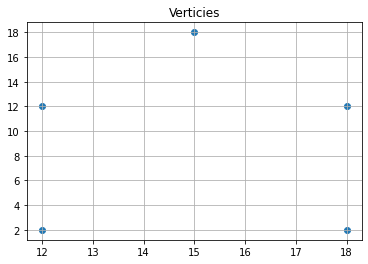

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd


%matplotlib inline

Y = np.array([2,12,18,12,2])
X = np.array([12,12,15,18,18])

fig,ax=plt.subplots()
ax.scatter(X,Y)
ax.grid()
ax.set_title('Verticies')

In [30]:
from shapely.geometry import Polygon, LineString, Point


## Shapely Objects

### Point(s)

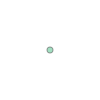

In [31]:
from shapely.geometry import Point

point = Point([X[0],Y[0]])

point

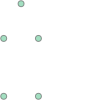

In [32]:
from shapely.geometry import MultiPoint

mulit_point = MultiPoint([x for x in zip(X, Y)])

mulit_point

### Polygon(s)

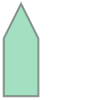

In [33]:
from shapely.geometry import Polygon

poly = Polygon([coord for coord in zip(X, Y)])

poly

[<shapely.geometry.polygon.Polygon object at 0x000002BBB11A3AC0>, <shapely.geometry.polygon.Polygon object at 0x000002BBB11A3AF0>, <shapely.geometry.polygon.Polygon object at 0x000002BBB4B84580>, <shapely.geometry.polygon.Polygon object at 0x000002BBB4B84760>]


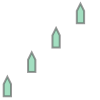

In [34]:
from shapely.geometry import MultiPolygon

Mpol = []
for i in range(0,61,20):
    Mpol.append(Polygon([coord for coord in zip(X+i, Y+i)]))

print(Mpol)
Mpoly = MultiPolygon(Mpol)

Mpoly

### Line(s)

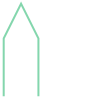

In [35]:
from shapely.geometry import LineString

line = LineString([x for x in zip(X, Y)])

line

[<shapely.geometry.linestring.LineString object at 0x000002BBB11B1190>, <shapely.geometry.linestring.LineString object at 0x000002BBB11B11C0>, <shapely.geometry.linestring.LineString object at 0x000002BBB11B11F0>, <shapely.geometry.linestring.LineString object at 0x000002BBB11B1250>]


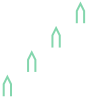

In [36]:
from shapely.geometry import MultiLineString

Mlin = []
for i in range(0,61,20):
    Mlin.append(LineString([coord for coord in zip(X+i, Y+i)]))

print(Mlin)
Mline = MultiLineString(Mlin)

Mline

## Unzip Data

- Below is a .zip file of census sub-divisions from Simply Analytics.
- We need to unzip it and inspect the metadata

In [37]:
import zipfile
Shape_file='SimplyAnalytics_Shapefiles_2021-11-18_04_29_59_93f600838bff00a6da2283b90dbf31c8'
with zipfile.ZipFile('data/'+Shape_file+'.zip', 'r') as zip_ref:
    zip_ref.extractall('data/Census/')


## Reading the shapefile

We can rely on [geopandas](https://geopandas.org/en/stable/), a spatial extension for pandas.  We can use Geopandas to read, manipulate, and write geospatial data.

* We can open .txt files with pandas to view the metadata

In [38]:
import geopandas as gpd

# the .read_file() function reads shapefiles
BC_FSA = gpd.read_file('data/Census/'+Shape_file+'.shp')

meta_data = pd.read_csv('data/Census/variable_names.txt',header=None,sep='#')
print('Vrriable Names: \n',meta_data.values)

BC_FSA

Vrriable Names: 
 [['VALUE0\t' ' Basics | Total Population, 2021']]


,spatial_id,name,VALUE0,geometry
0,V0A,"V0A, BC (FSA)",15090.0,"POLYGON ((-117.98783 52.50001, -117.96679 52.4..."
1,V0B,"V0B, BC (FSA)",35496.0,"MULTIPOLYGON (((-116.88531 49.86933, -116.8705..."
2,V0C,"V0C, BC (FSA)",25232.0,"MULTIPOLYGON (((-120.00003 56.05796, -120.0013..."
3,V0E,"V0E, BC (FSA)",68747.0,"POLYGON ((-119.25712 53.17662, -119.24281 53.1..."
4,V0G,"V0G, BC (FSA)",24806.0,"MULTIPOLYGON (((-117.80679 49.12324, -117.8068..."
...,...,...,...,...
184,V9V,"V9V, BC (FSA)",11526.0,"POLYGON ((-124.03259 49.25047, -124.03211 49.2..."
185,V9W,"V9W, BC (FSA)",31861.0,"POLYGON ((-125.34262 50.11964, -125.33910 50.1..."
186,V9X,"V9X, BC (FSA)",11585.0,"POLYGON ((-124.63753 49.28484, -124.63742 49.2..."
187,V9Y,"V9Y, BC (FSA)",26971.0,"MULTIPOLYGON (((-124.66614 48.81381, -124.6659..."


## Editing Data

In [39]:

## Note - This is the terminology used by the census
## It can be found in the variable_name file that comes with the download
BC_FSA = BC_FSA.rename(columns={
'VALUE0': 'Population',
})

BC_FSA.head()

,spatial_id,name,Population,geometry
0,V0A,"V0A, BC (FSA)",15090.0,"POLYGON ((-117.98783 52.50001, -117.96679 52.4..."
1,V0B,"V0B, BC (FSA)",35496.0,"MULTIPOLYGON (((-116.88531 49.86933, -116.8705..."
2,V0C,"V0C, BC (FSA)",25232.0,"MULTIPOLYGON (((-120.00003 56.05796, -120.0013..."
3,V0E,"V0E, BC (FSA)",68747.0,"POLYGON ((-119.25712 53.17662, -119.24281 53.1..."
4,V0G,"V0G, BC (FSA)",24806.0,"MULTIPOLYGON (((-117.80679 49.12324, -117.8068..."


## Plotting the Data

- Display the data and inspect the projection

No handles with labels found to put in legend.


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

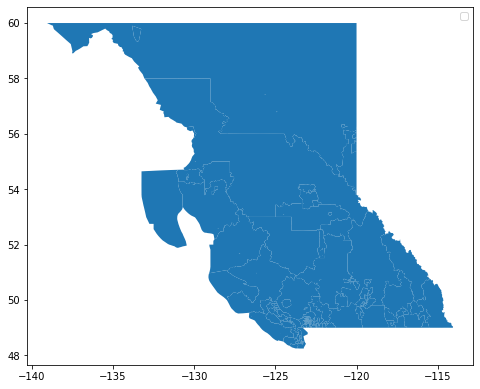

In [40]:
fig,ax=plt.subplots(figsize=(8,8))
BC_FSA.plot(ax=ax)
ax.legend()

BC_FSA.crs

## Re-project the Data

No handles with labels found to put in legend.


<Projected CRS: EPSG:3005>
Name: NAD83 / BC Albers
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Canada - British Columbia.
- bounds: (-139.04, 48.25, -114.08, 60.01)
Coordinate Operation:
- name: British Columbia Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

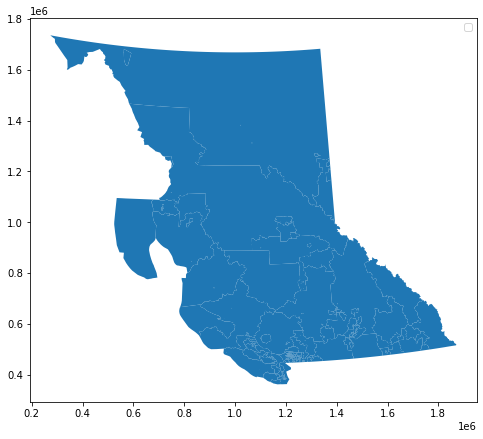

In [41]:
BC_FSA_Albers = BC_FSA.to_crs('EPSG:3005')

fig,ax=plt.subplots(figsize=(8,8))
BC_FSA_Albers.plot(ax=ax)
ax.legend()

BC_FSA_Albers.crs

## Inspect the Geometry

In [42]:
BC_FSA_Albers.area

0      2.118938e+10
1      2.073793e+10
2      3.292633e+11
3      5.358337e+10
4      1.622650e+10
           ...     
184    7.946664e+06
185    1.081930e+08
186    1.165130e+09
187    1.875408e+09
188    5.472391e+08
Length: 189, dtype: float64

## Map by a Column

<AxesSubplot:>

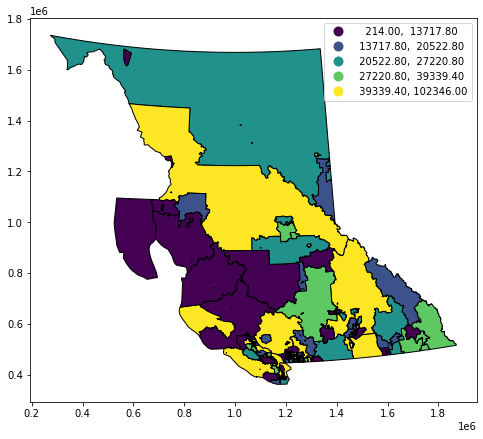

In [43]:
fig,ax=plt.subplots(figsize=(8,8))
BC_FSA_Albers.plot(column='Population',ax=ax,legend=True,scheme="quantiles",edgecolor='k')

## Spatial Overlay

Text(0.5, 1.0, 'Clip Layer')

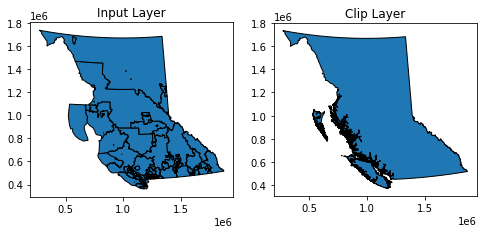

In [44]:
# BC_Boundary.to_file('Data/Census/BC_Boudary_File.shp')
BC_Boundary = gpd.read_file('Data/Census/BC_Boudary_File.shp')

fig,ax = plt.subplots(1,2,figsize=(8,5))
BC_FSA_Albers.plot(edgecolor='k',ax=ax[0])
BC_Boundary.plot(edgecolor='k',ax=ax[1])

ax[0].set_title('Input Layer')
ax[1].set_title('Clip Layer')


## Clip

This will take a little while to process

Text(0.5, 1.0, 'Final Result')

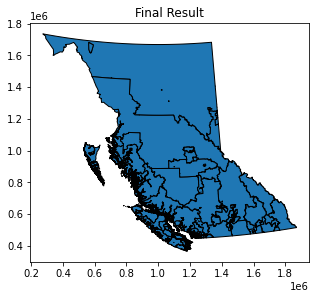

In [45]:


BC_FSA_Clip = gpd.clip(BC_FSA_Albers,BC_Boundary)

fig,ax = plt.subplots(figsize=(5,7))
BC_FSA_Clip.plot(edgecolor='k',ax=ax)
ax.set_title('Final Result')

## Calculate Population Density

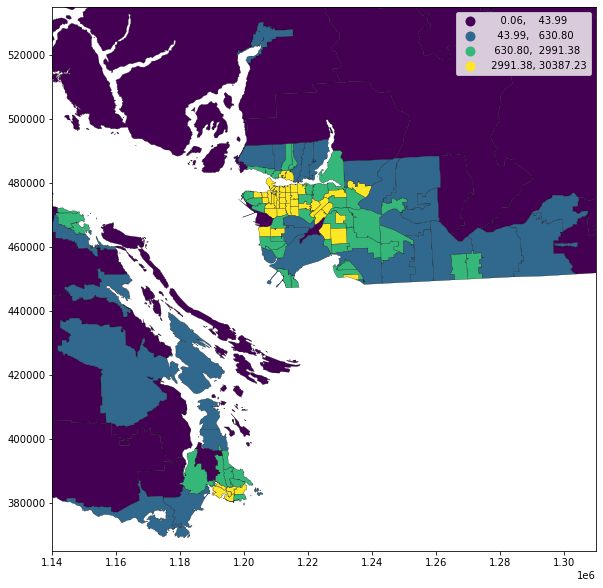

In [46]:
BC_FSA_Clip['Pop_Density'] = BC_FSA_Clip['Population']/BC_FSA_Clip.area*1e6
BC_FSA_Clip['Pop_Density']=BC_FSA_Clip['Pop_Density'].fillna(0)

fig,ax=plt.subplots(figsize=(10,10))
BC_FSA_Clip.plot(column='Pop_Density',ax=ax,legend=True,scheme="User_Defined", 
         classification_kwds=dict(bins=[
             BC_FSA_Clip['Pop_Density'].quantile(.25),
             BC_FSA_Clip['Pop_Density'].quantile(.5),
             BC_FSA_Clip['Pop_Density'].quantile(.75),
             BC_FSA_Clip['Pop_Density'].max()]),
                    edgecolor='black',linewidth=.25)

ax.grid()

# ## Set Zoom & Turn Grid off
x = 1.225e6
y = 0.45e6
v = 8.5e4 
h = 8.5e4

ax.set_xlim(x-h,x+h)
ax.set_ylim(y-h,y+h)
ax.grid()

# BC_FSA_Clip.to_file('data//BC_FSAisions.shp')



## Data Classification

Community Type Summary BC
Community_Type
Rural     86
Urban    103
Name: name, dtype: int64


Text(0.5, 1.0, 'Community Type SW BC')

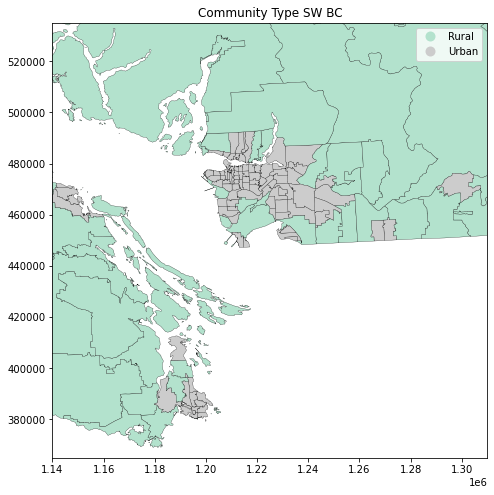

In [47]:
BC_FSA_Clip.loc[((BC_FSA_Clip['Pop_Density']<=400)|(BC_FSA_Clip['Population']<=1000)),
                    'Community_Type']='Rural'

BC_FSA_Clip.loc[(BC_FSA_Clip['Community_Type']!='Rural'),
                    'Community_Type']='Urban'

print('Community Type Summary BC')
print(BC_FSA_Clip.groupby('Community_Type').count()['name'].sort_values())


fig,ax=plt.subplots(figsize=(8,8))
BC_FSA_Clip.plot(column='Community_Type',ax=ax,legend=True,cmap='Pastel2',edgecolor='k',linewidth=.25)

ax.set_xlim(x-h,x+h)
ax.set_ylim(y-h,y+h)
# ax.grid()

ax.set_title('Community Type SW BC')



# Saving Data

## Shapefiles

We can save new layer as a shapefile.  [Shapefiles](https://en.wikipedia.org/wiki/Shapefile) are only one type of vector file.  Note the **"UserWarnings"**  

* The first one isn't too serious, but it explains why the data came with a generic column header
    *   They have certain restrictions to minimize storage space (eg. limiting column names), they aren't human readable, and they split the data into multiple files.

In [48]:
# BC_FSA_Clip.to_file('data/Outputs/BC_FSA.shp')
print(BC_FSA_Clip.groupby(BC_FSA_Clip['geometry'].type).count()['Population'])
BC_FSA_Clip.loc[BC_FSA_Clip['geometry'].type !='GeometryCollection']

GeometryCollection      1
MultiPolygon           61
Polygon               127
Name: Population, dtype: int64


,spatial_id,name,Population,geometry,Pop_Density,Community_Type
0,V0A,"V0A, BC (FSA)",15090.0,"POLYGON ((1561469.899 849012.661, 1561469.879 ...",0.712263,Rural
1,V0B,"V0B, BC (FSA)",35496.0,"MULTIPOLYGON (((1654601.543 581519.505, 165459...",1.712067,Rural
2,V0C,"V0C, BC (FSA)",25232.0,"MULTIPOLYGON (((1372803.084 1240250.740, 13728...",0.076632,Rural
3,V0E,"V0E, BC (FSA)",68747.0,"POLYGON ((1449972.623 929441.227, 1450608.723 ...",1.283004,Rural
4,V0G,"V0G, BC (FSA)",24806.0,"MULTIPOLYGON (((1597439.456 490207.415, 159722...",1.528792,Rural
...,...,...,...,...,...,...
184,V9V,"V9V, BC (FSA)",11526.0,"POLYGON ((1147789.602 470894.901, 1147715.667 ...",1852.201590,Urban
185,V9W,"V9W, BC (FSA)",31861.0,"POLYGON ((1046999.905 566604.420, 1046901.562 ...",328.473534,Rural
186,V9X,"V9X, BC (FSA)",11585.0,"MULTIPOLYGON (((1099223.059 474838.000, 109866...",10.048666,Rural
187,V9Y,"V9Y, BC (FSA)",26971.0,"MULTIPOLYGON (((1098126.162 422663.654, 109812...",14.499068,Rural


## Geojson

We can save the new layer as a [geojson](https://en.wikipedia.org/wiki/GeoJSON) file to get around the issue.
* This is a simple file type often used in web-centered applications that stores data as a **human readable** dictionary.
* The file takes up more space, but is also a bit more accessible/flexible.


In [49]:
print(BC_FSA_Clip.groupby(BC_FSA_Clip['geometry'].type).count()['Population'])
BC_FSA_Clip.to_file("data/Outputs/BC_FSA.json", driver = "GeoJSON")

GeometryCollection      1
MultiPolygon           61
Polygon               127
Name: Population, dtype: int64
